In [1]:
import cv2 as cv
import math
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#загрузки для тестов
gauss_test = cv.imread('catmask.jpg')
gauss_test = cv.cvtColor(gauss_test, cv.COLOR_BGR2RGB)

padding_test = cv.imread('catmask.jpg')
padding_test = cv.cvtColor(padding_test, cv.COLOR_BGR2RGB)

downsample_test = cv.imread('catmask.jpg')
downsample_test = cv.cvtColor(downsample_test, cv.COLOR_BGR2RGB)

sobel_test = cv.imread('catmask.jpg')
sobel_test = cv.cvtColor(sobel_test, cv.COLOR_BGR2RGB)




In [3]:
# Ядро Гаусса
def get_gauss_kernel(size, sigma) :
    sigma_const = 2*sigma*sigma
    kernel = np.zeros((size, size))
    half = (size // 2)
    for x in range(size) :
        for y in range(size) :
            step = -((x - half) * (x - half) + (y - half)) / sigma_const
            kernel[x][y] = 1 / (math.pi * sigma_const) * math.exp(step)
    
    normalization = np.sum(kernel)
    for i in range(size) :
        for j in range(size) :
            kernel[i][j] /= normalization
            
    return kernel

In [4]:
# умножения пикселя на ядро
def mult_kernel(image, i, j, kernel) :
    kernel_size, _ = kernel.shape
    half_kernel = kernel_size //2
    result = [0, 0, 0]
    start_img_i = i - half_kernel
    start_img_j = j - half_kernel
    
    for i in range(kernel_size) :
        for j in range(kernel_size) :
            result += (image[start_img_i + i][start_img_j + j] * kernel[i][j])
    return result
# проход ядром по картинке
def pass_kernel_through_image(image,kernel) :
    kernel_size, _ = kernel.shape
    half_kernel = kernel_size //2
    width, height, _ = image.shape
    new_width = width - half_kernel - half_kernel
    new_height = height - half_kernel - half_kernel
    image_result = image.copy()
    image_with_padding = add_padding(image, half_kernel)
    for i in range(new_width) :
        for j in range(new_height) :
            image_result[i][j] = mult_kernel(image_with_padding, i+half_kernel, j+half_kernel, kernel)
            
    return image_result
    

In [5]:
def add_padding(image, padding_size) :
    width, height, _ = image.shape
    new_image = np.zeros((width+2*padding_size, height+2*padding_size, 3), np.uint8)
    new_width, new_height, _ = new_image.shape    
    
    for i in range(width) :
        for j in range(height) :
            new_image[i+padding_size][j+padding_size] = image[i][j]
    for i in range(width) :
        for j in range(padding_size) :
            new_image[i+padding_size][j] = image[i][padding_size-j]
            new_image[i+padding_size][new_height -j -1] = image[i][height-padding_size+j-1]
    for i in range(padding_size) :
        for j in range(new_height) :
            new_image[i][j] = new_image[2*padding_size-i][j]
            new_image[new_width-i-1][j] = new_image[width+i-1][j]          
    return new_image

720 720


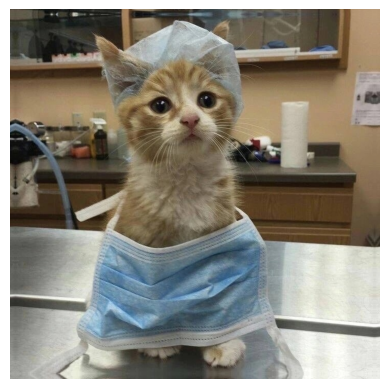

In [6]:
#тестим паддинг
padding_test = add_padding(padding_test, 10)
plt.axis('off')
plt.imshow(padding_test)
h,w,_ = padding_test.shape
print(h,w)

In [7]:
def gauss_blur(image,kernel_size,sigma):
    kernel = get_gauss_kernel(kernel_size, sigma)      
    result_image = pass_kernel_through_image(image, kernel)
    
    return result_image

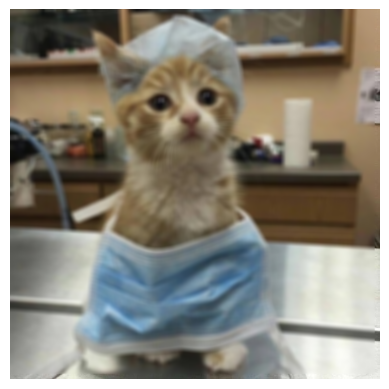

In [8]:
#тестим блюр
kernel_size = 11
sigma = 5
gauss_test = gauss_blur(gauss_test, kernel_size, sigma)
plt.axis('off')
plt.imshow(gauss_test)

In [9]:
# https://www.researchgate.net/publication/49619233_Image_Segmentation_using_Extended_Edge_Operator_for_Mammographic_Images

def get_gray_pixel(pixel) :
    return 0.299*pixel[0] + 0.5876*pixel[1] + 0.114*pixel[2]
def get_sobel_kernel_x(kernel_size) :
    kernel = np.zeros((kernel_size, kernel_size))
    main_el = 1
    half = kernel_size // 2
    for i in range(half) :
        main_el *=-1    
    for i in range(half) :          
        for j in range(kernel_size) :
            kernel[half+1+i][j] = -1 * main_el
            kernel[half-1-i][j] = main_el            
        main_el *= 2
        kernel[half+1+i][half] = -1 * main_el
        kernel[half-1-i][half] = main_el        
    return kernel

def get_sobel_kernel_y(kernel_size) :
    kernel = np.zeros((kernel_size, kernel_size))
    main_el = 1
    half = kernel_size // 2
    for i in range(half) :
        main_el *=-1    
    for i in range(half) :          
        for j in range(kernel_size) :
            kernel[j][half+1+i] = -1 * main_el
            kernel[j][half-1-i] = main_el            
        main_el *= 2
        kernel[half][half+1+i] = -1 * main_el
        kernel[half][half-1-i] = main_el        
    return kernel


In [10]:
#downsample без предварительной обработки
def get_downsample_image(image) :
    width, height, _ = image.shape
    new_width = width // 2
    new_height = height // 2
    new_image = np.zeros((new_width, new_height, 3), np.uint8)
    for i in range(new_width) :
        for j in range(new_height) :
            new_image[i][j] = image[i*2][j*2]
    return new_image

700 700
350 350


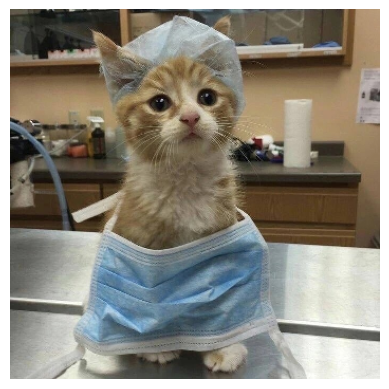

In [11]:
#тест downsample
h,w,_ = downsample_test.shape
print(h,w)
downsample_test = get_downsample_image(downsample_test)
plt.axis('off')
plt.imshow(downsample_test)
h,w,_ = downsample_test.shape
print(h,w)

In [12]:
def sobel_filter(image, kernel_size) :
    kernel_gx = get_sobel_kernel_x(kernel_size)
    kernel_gy = get_sobel_kernel_y(kernel_size)    
    half_kernel = kernel_size // 2
    image_with_padding = add_padding(image, half_kernel)
    width, height, _ = image.shape
    result_image = np.zeros((width, height, 3), np.uint8)
    for i in range(width) :
        for j in range(height) :
            sobel_pixel_x = get_gray_pixel(mult_kernel(image_with_padding, i+half_kernel, j+half_kernel, kernel_gx))
            sobel_pixel_y = get_gray_pixel(mult_kernel(image_with_padding, i+half_kernel, j+half_kernel, kernel_gy))
            result_image[i][j] = math.sqrt(sobel_pixel_x*sobel_pixel_x + sobel_pixel_y*sobel_pixel_y)
            #result_image[i][j] = math.abs(sobel_pixel_x) + math.abs(sobel_pixel_y)
            
    return result_image    

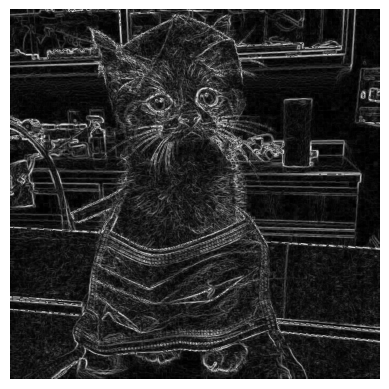

In [13]:
#тестим sobel_filter
kernel_size = 3
sobel_test = sobel_filter(sobel_test, kernel_size)
plt.axis('off')
plt.imshow(sobel_test)

In [14]:
# image - стартовое изображение
# gauss_kernel_size - размер ядра для гаусса
# sigma - начальная сигма
# level - уровень
# octave -  октава
#Масштаб сглаживающего фильтра ведет к росту призводных и улучшает нахождение границ
def pyramid_scale_space(image, gauss_kernel_size, sigma, level, octave) :
    k=1 # интервал между масштабами в октаве
    downsample_image = image.copy()    
    for i in range(level) :
        for j in range(octave) :
            k *= 2**(1/octave)
            downsample_image = gauss_blur(downsample_image, kernel_size, sigma*k)
        downsample_image = get_downsample_image(downsample_image)
    return downsample_image

175 175


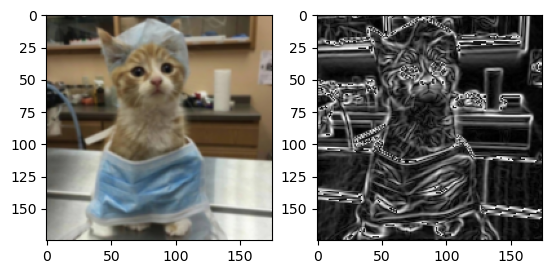

In [15]:
pyramid_test = cv.imread('catmask.jpg')
pyramid_test = cv.cvtColor(pyramid_test, cv.COLOR_BGR2RGB)
gauss_kernel_size = 3
sigma = 1
level = 2
octave = 2
pyramid_test = pyramid_scale_space(pyramid_test, gauss_kernel_size, sigma, level, octave)
sobel_pyramid_test = sobel_filter(pyramid_test, 3)
plt.axis('off')
plt.subplot(121)
plt.imshow(pyramid_test)
plt.subplot(122)
plt.imshow(sobel_pyramid_test)
h,w,_=pyramid_test.shape
print(h,w)

350 350


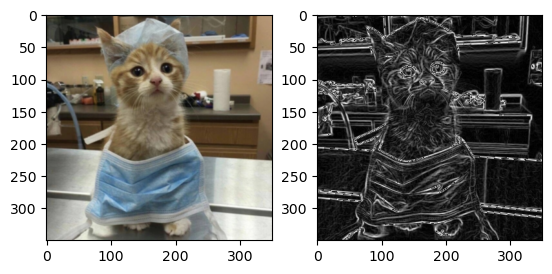

In [16]:
pyramid_test = cv.imread('catmask.jpg')
pyramid_test = cv.cvtColor(pyramid_test, cv.COLOR_BGR2RGB)
gauss_kernel_size = 3
sigma = 1
level = 1
octave = 2
pyramid_test = pyramid_scale_space(pyramid_test, gauss_kernel_size, sigma, level, octave)
sobel_pyramid_test = sobel_filter(pyramid_test, 3)
plt.axis('off')
plt.subplot(121)
plt.imshow(pyramid_test)
plt.subplot(122)
plt.imshow(sobel_pyramid_test)
h,w,_=pyramid_test.shape
print(h,w)

350 350


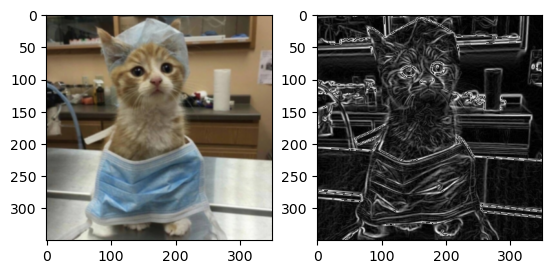

In [17]:
pyramid_test = cv.imread('catmask.jpg')
pyramid_test = cv.cvtColor(pyramid_test, cv.COLOR_BGR2RGB)
gauss_kernel_size = 3
sigma = 1
level = 1
octave = 4
pyramid_test = pyramid_scale_space(pyramid_test, gauss_kernel_size, sigma, level, octave)
sobel_pyramid_test = sobel_filter(pyramid_test, 3)
plt.axis('off')
plt.subplot(121)
plt.imshow(pyramid_test)
plt.subplot(122)
plt.imshow(sobel_pyramid_test)
h,w,_=pyramid_test.shape
print(h,w)

87 87


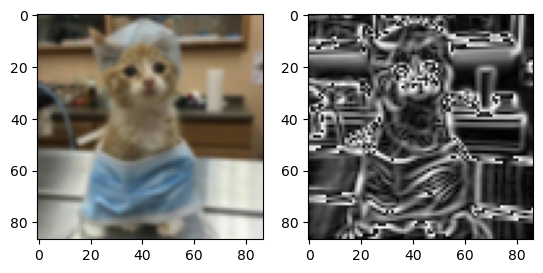

In [18]:
pyramid_test = cv.imread('catmask.jpg')
pyramid_test = cv.cvtColor(pyramid_test, cv.COLOR_BGR2RGB)
gauss_kernel_size = 3
sigma = 1
level = 3
octave = 2
pyramid_test = pyramid_scale_space(pyramid_test, gauss_kernel_size, sigma, level, octave)
sobel_pyramid_test = sobel_filter(pyramid_test, 3)
plt.axis('off')
plt.subplot(121)
plt.imshow(pyramid_test)
plt.subplot(122)
plt.imshow(sobel_pyramid_test)
h,w,_=pyramid_test.shape
print(h,w)

350 350


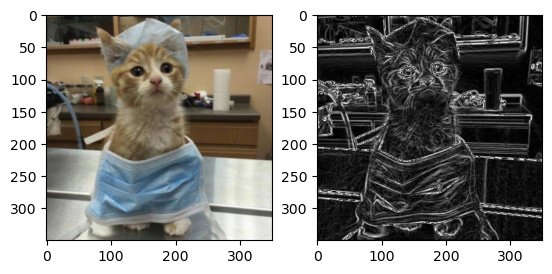

In [19]:
pyramid_test = cv.imread('catmask.jpg')
pyramid_test = cv.cvtColor(pyramid_test, cv.COLOR_BGR2RGB)
gauss_kernel_size = 5
sigma = 3
level = 1
octave = 2
pyramid_test = pyramid_scale_space(pyramid_test, gauss_kernel_size, sigma, level, octave)
sobel_pyramid_test = sobel_filter(pyramid_test, 3)
plt.axis('off')
plt.subplot(121)
plt.imshow(pyramid_test)
plt.subplot(122)
plt.imshow(sobel_pyramid_test)
h,w,_=pyramid_test.shape
print(h,w)

350 350


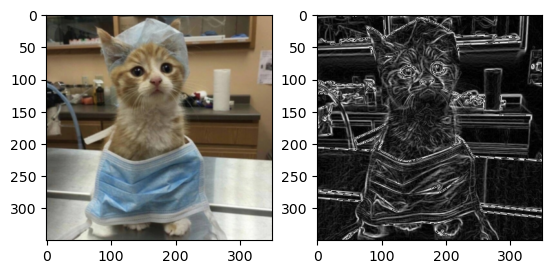

In [20]:
pyramid_test = cv.imread('catmask.jpg')
pyramid_test = cv.cvtColor(pyramid_test, cv.COLOR_BGR2RGB)
gauss_kernel_size = 11
sigma = 5
level = 1
octave = 2
pyramid_test = pyramid_scale_space(pyramid_test, gauss_kernel_size, sigma, level, octave)
sobel_pyramid_test = sobel_filter(pyramid_test, 3)
plt.axis('off')
plt.subplot(121)
plt.imshow(pyramid_test)
plt.subplot(122)
plt.imshow(sobel_pyramid_test)
h,w,_=pyramid_test.shape
print(h,w)

175 175


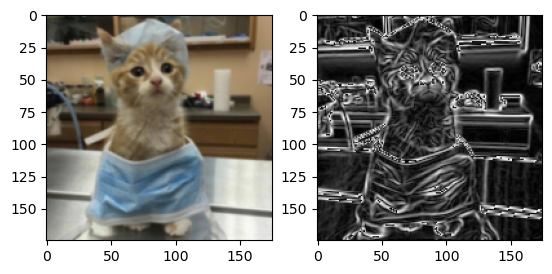

In [21]:
pyramid_test = cv.imread('catmask.jpg')
pyramid_test = cv.cvtColor(pyramid_test, cv.COLOR_BGR2RGB)
gauss_kernel_size = 11
sigma = 5
level = 2
octave = 2
pyramid_test = pyramid_scale_space(pyramid_test, gauss_kernel_size, sigma, level, octave)
sobel_pyramid_test = sobel_filter(pyramid_test, 3)
plt.axis('off')
plt.subplot(121)
plt.imshow(pyramid_test)
plt.subplot(122)
plt.imshow(sobel_pyramid_test)
h,w,_=pyramid_test.shape
print(h,w)

175 175


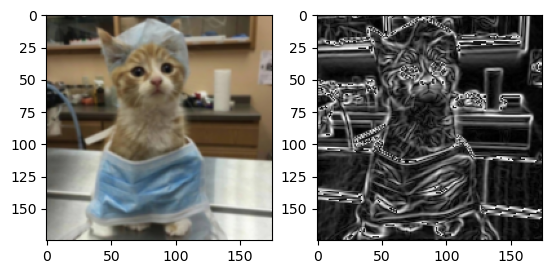

In [22]:
pyramid_test = cv.imread('catmask.jpg')
pyramid_test = cv.cvtColor(pyramid_test, cv.COLOR_BGR2RGB)
gauss_kernel_size = 11
sigma = 1
level = 2
octave = 2
pyramid_test = pyramid_scale_space(pyramid_test, gauss_kernel_size, sigma, level, octave)
sobel_pyramid_test = sobel_filter(pyramid_test, 3)
plt.axis('off')
plt.subplot(121)
plt.imshow(pyramid_test)
plt.subplot(122)
plt.imshow(sobel_pyramid_test)
h,w,_=pyramid_test.shape
print(h,w)

43 43


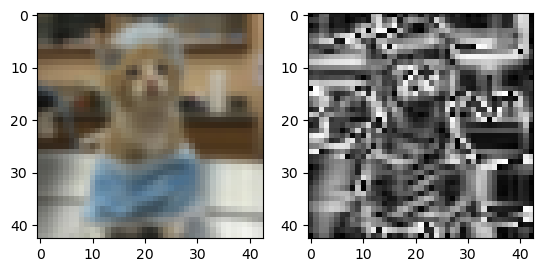

In [23]:
pyramid_test = cv.imread('catmask.jpg')
pyramid_test = cv.cvtColor(pyramid_test, cv.COLOR_BGR2RGB)
gauss_kernel_size = 5
sigma = 3
level = 4
octave = 2
pyramid_test = pyramid_scale_space(pyramid_test, gauss_kernel_size, sigma, level, octave)
sobel_pyramid_test = sobel_filter(pyramid_test, 3)
plt.axis('off')
plt.subplot(121)
plt.imshow(pyramid_test)
plt.subplot(122)
plt.imshow(sobel_pyramid_test)
h,w,_=pyramid_test.shape
print(h,w)